In [ ]:
import pandas as pd
from ast import literal_eval
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error


In [109]:
from utils.amenity_matching import AMENITY_PATTERNS
from utils.amenity_matching import AMENITY_CATEGORIES
from utils.amenity_matching import (
    append_amenity_dummies,
    aggregate_amenity_categories,
    find_matching_patterns,
)

from utils.preprocess import (
    keep_only_relevant_features,
    calculate_euclidean_distance,
    missing_data_preprocess,
    preprocess_data,
    format_datetime_and_categorical,
)

from utils.formula_handling import create_formula, cv_reg, summarize_cv
from utils.cv_evaluation import retrieve_cv_summary, summarize_multiple_cv_results
from utils.plotting import (
    plot_predictions_vs_actuals,
    plot_multiple_predictions_vs_actuals,
    plot_feature_importances,
)

# Importing the base dataset

In [110]:
df = pd.read_csv("San Francisco Q4.csv")

In [111]:
df.shape[0] - df["price"].isna().sum()

np.int64(6228)

In [112]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7863 entries, 0 to 7862
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7863 non-null   int64  
 1   listing_url                                   7863 non-null   object 
 2   scrape_id                                     7863 non-null   int64  
 3   last_scraped                                  7863 non-null   object 
 4   source                                        7863 non-null   object 
 5   name                                          7863 non-null   object 
 6   description                                   7742 non-null   object 
 7   neighborhood_overview                         4980 non-null   object 
 8   picture_url                                   7863 non-null   object 
 9   host_id                                       7863 non-null   i

In [114]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7863.0,4.338911e+17,4.975284e+17,9.580000e+02,2.368268e+07,5.058181e+07,9.466094e+17,1.303453e+18
scrape_id,7863.0,2.024120e+13,3.906498e-03,2.024120e+13,2.024120e+13,2.024120e+13,2.024120e+13,2.024120e+13
host_id,7863.0,1.668960e+08,1.962473e+08,1.169000e+03,8.056112e+06,6.499665e+07,3.107313e+08,6.646487e+08
host_listings_count,7863.0,2.326974e+02,8.529691e+02,1.000000e+00,1.000000e+00,3.000000e+00,2.300000e+01,4.591000e+03
host_total_listings_count,7863.0,2.953495e+02,1.069227e+03,1.000000e+00,2.000000e+00,5.000000e+00,3.700000e+01,9.046000e+03
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,7863.0,3.776988e+01,2.317021e-02,3.770828e+01,3.775503e+01,3.777530e+01,3.778841e+01,3.781101e+01
longitude,7863.0,-1.224302e+02,2.709925e-02,-1.225125e+02,-1.224428e+02,-1.224222e+02,-1.224109e+02,-1.223660e+02
accommodates,7863.0,3.227394e+00,2.028399e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,6236.0,1.326090e+00,7.639791e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.500000e+00,1.000000e+01


# Preprocessing

## Amenities extraction

Amenities are stored in a string, which looks like a python list. We can leverage literal_eval, to extract true lists, and then explode to create an unnested array.

### Overview of amenities

In [115]:
df["amenities"] = df["amenities"].apply(literal_eval)

In [116]:
amenities_df = df["amenities"].explode().value_counts().reset_index()

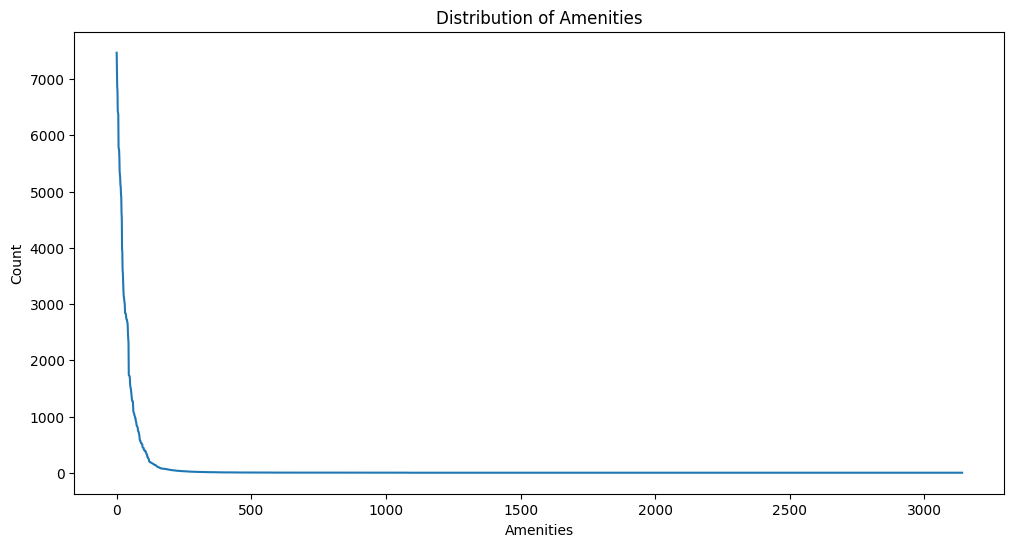

In [117]:
# Plot the distribution of amenities
plt.figure(figsize=(12, 6))
sns.lineplot(data=amenities_df, x=amenities_df.index, y="count")
plt.xlabel("Amenities")
plt.ylabel("Count")
plt.title("Distribution of Amenities")
plt.show()

In [118]:
# core amenities are which appear at least in 10 apartments
core_amenities = amenities_df[amenities_df["count"] > 10]["amenities"].tolist()

In [119]:
core_amenities

['Smoke alarm',
 'Wifi',
 'Carbon monoxide alarm',
 'Essentials',
 'Hair dryer',
 'Hangers',
 'Hot water',
 'Iron',
 'Kitchen',
 'Shampoo',
 'Fire extinguisher',
 'Bed linens',
 'Microwave',
 'Self check-in',
 'Dishes and silverware',
 'Heating',
 'Dedicated workspace',
 'Refrigerator',
 'Cooking basics',
 'First aid kit',
 'TV',
 'Extra pillows and blankets',
 'Coffee maker',
 'Private entrance',
 'Long term stays allowed',
 'Luggage dropoff allowed',
 'Washer',
 'Free street parking',
 'Body soap',
 'Dishwasher',
 'Shower gel',
 'Hot water kettle',
 'Cleaning products',
 'Exterior security cameras on property',
 'Oven',
 'Dining table',
 'Conditioner',
 'Bathtub',
 'Freezer',
 'Toaster',
 'Wine glasses',
 'Room-darkening shades',
 'Dryer',
 'Coffee',
 'Stove',
 'Laundromat nearby',
 'Outdoor furniture',
 'Baking sheet',
 'Elevator',
 'Keypad',
 'Pets allowed',
 'Air conditioning',
 'Clothing storage',
 'Lockbox',
 'Outdoor dining area',
 'Mini fridge',
 'Books and reading material',


### Peek into what amenities are matched
During the process, the below staps were iteratively called, while updating the dictionary with newer and newer results.
The logic is, that we optimize our matching on the core subset of amenities, defined by appearing at least in 10 households.
Then, we check for the entire dataset our progress.

In [120]:
# Create a new dataframe
core_amenities_df = pd.DataFrame(core_amenities, columns=["amenity"])

# Find matching patterns for each amenity
core_amenities_df["matching_patterns"] = core_amenities_df["amenity"].apply(
    lambda x: find_matching_patterns(x, AMENITY_PATTERNS)
)

# Add a boolean column to indicate if any match was found
core_amenities_df["match_found"] = core_amenities_df["matching_patterns"].apply(
    lambda x: len(x) > 0
)

core_amenities_df

,amenity,matching_patterns,match_found
0,Smoke alarm,[fire_safety],True
1,Wifi,[wifi],True
2,Carbon monoxide alarm,[fire_safety],True
3,Essentials,[household_essentials],True
4,Hair dryer,"[dryer, hair_dryer, washer_dryer_features]",True
...,...,...,...
349,Other gas stove,[stove],True
350,Frigidaire gas stove,[stove],True
351,HDTV with Chromecast,[tv],True
352,HDTV with Fire TV,[tv],True


In [121]:
core_amenities_df[~core_amenities_df["match_found"]]

,amenity,matching_patterns,match_found


In [122]:
all_amenities_df = df["amenities"].explode().value_counts().reset_index()

In [123]:
all_amenities_df["matching_patterns"] = all_amenities_df["amenities"].apply(
    lambda x: find_matching_patterns(x, AMENITY_PATTERNS)
)
all_amenities_df["match_found"] = all_amenities_df["matching_patterns"].apply(
    lambda x: len(x) > 0
)

In [124]:
all_amenities_df[~all_amenities_df["match_found"]]

,amenities,count,matching_patterns,match_found
370,Free carport on premises – 1 space,9,[],False
379,Climbing wall,8,[],False
386,Boat slip,8,[],False
420,Batting cage,7,[],False
608,Mini golf,3,[],False
725,Ironing board,3,[],False
788,Skate ramp,2,[],False
797,Free carport on premises,2,[],False
970,Wine cellar,2,[],False
993,Ice machine,2,[],False


For those amenities that are present only for <10 households, dummy creation is not suggested. This is because we want to avoid too granular amenity matching and resulting overfitting.
- It is of course possible, that these amenities could be part of already captured amenity features. Ommitting such a low number of cases however would yield no significant drawbacks.

**Result**
We have only 16 amenity instances out of around 3000 that are ommitted, yielding a good coverage.

### Creating amenity dummies, and also amenity category dummies

In [125]:
# Add amenity categories to the dataframe
df = append_amenity_dummies(df, "amenities", AMENITY_PATTERNS)

Processing patterns:   0%|          | 0/86 [00:00<?, ?it/s]

Processing patterns: 100%|██████████| 86/86 [00:13<00:00,  6.30it/s]


Categorize amenities

In [126]:
df = aggregate_amenity_categories(df, AMENITY_CATEGORIES)

Storing column name groups as a list. We will use these to progressively increase the granularity and number of variables.

In [127]:
amenity_granular_columns = [col for col in df.columns if col.startswith("amenity_")]
amenity_category_coverage_columns = [
    col for col in df.columns if col.startswith("category_coverage_")
]
amenity_category_any_columns = [
    col for col in df.columns if col.startswith("category_any_")
]

In [128]:
print(f"Granular amenity columns: {amenity_granular_columns}")
print(f"Category coverage columns: {amenity_category_coverage_columns}")
print(f"Category any columns: {amenity_category_any_columns}")

Granular amenity columns: ['amenity_wifi', 'amenity_tv', 'amenity_air_conditioning', 'amenity_heating', 'amenity_washer', 'amenity_dryer', 'amenity_kitchen', 'amenity_oven', 'amenity_microwave', 'amenity_bbq_grill', 'amenity_fridge', 'amenity_fire_safety', 'amenity_security', 'amenity_parking', 'amenity_pool', 'amenity_hot_tub', 'amenity_sauna', 'amenity_gym', 'amenity_children_friendly', 'amenity_shower_equipment', 'amenity_hair_dryer', 'amenity_workspace', 'amenity_pets_allowed', 'amenity_outdoor_space', 'amenity_entertainment', 'amenity_smart_lock', 'amenity_self_checkin', 'amenity_coffee_maker', 'amenity_storage_space', 'amenity_scenic_view', 'amenity_outdoor_seating', 'amenity_ev_charger', 'amenity_baby_facilities', 'amenity_dishes_silverware', 'amenity_cooking_basics', 'amenity_dishwasher', 'amenity_dining_table', 'amenity_wine_glasses', 'amenity_toaster', 'amenity_blender', 'amenity_stove', 'amenity_rice_maker', 'amenity_bread_maker', 'amenity_bbq_utensils', 'amenity_trash_compa

In [129]:
# Describe the amenity categorical columns to see if all variables have some variance. - They do.
df[
    amenity_granular_columns
    + amenity_category_any_columns
    + amenity_category_coverage_columns
].describe().T

,count,mean,std,min,25%,50%,75%,max
amenity_wifi,7863.0,0.991352,0.092598,0.0,1.0,1.0,1.0,1.0
amenity_tv,7863.0,0.848404,0.358652,0.0,1.0,1.0,1.0,1.0
amenity_air_conditioning,7863.0,0.229429,0.420492,0.0,0.0,0.0,0.0,1.0
amenity_heating,7863.0,0.835050,0.371159,0.0,1.0,1.0,1.0,1.0
amenity_washer,7863.0,0.648607,0.477436,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
category_coverage_household,7863.0,6.046038,2.513392,0.0,4.0,6.0,8.0,11.0
category_coverage_accessibility,7863.0,0.761541,0.748431,0.0,0.0,1.0,1.0,3.0
category_coverage_smart_home,7863.0,1.018950,0.827240,0.0,0.0,1.0,2.0,2.0
category_coverage_indoor_comfort,7863.0,0.166222,0.389010,0.0,0.0,0.0,0.0,2.0


## Distance from center

In [130]:
# Example coordinates for the reference point (Union Square)
union_square_latitude = 37.787994
union_square_longitude = -122.407437

# Create a new column 'distance_to_center' in the dataframe
df["distance_to_center"] = calculate_euclidean_distance(
    df["latitude"], df["longitude"], union_square_latitude, union_square_longitude
)

## Missing data

**Overview:** The below table helps us to overview the coverage by each variable

In [131]:
# Calculate the percentage of missing data for each column
missing_data_percentage = df.isnull().mean() * 100

# Round the missing percentage to 3 decimal places
missing_data_percentage = missing_data_percentage.round(3)

# Create a coverage table
coverage_table = pd.DataFrame(
    {
        "Column": missing_data_percentage.index,
        "Missing Percentage": missing_data_percentage.values,
    }
)

# Display the coverage table
coverage_table.sort_values(by="Missing Percentage", ascending=False, inplace=True)
coverage_table.reset_index(drop=True, inplace=True)

missing_values_coverage_table = coverage_table[coverage_table["Missing Percentage"] > 0].copy()
missing_values_coverage_table["Missing Percentage"] = missing_values_coverage_table["Missing Percentage"].apply(lambda x: f"{x:.3f}%")
missing_values_coverage_table

,Column,Missing Percentage
0,calendar_updated,100.000%
1,neighbourhood_group_cleansed,100.000%
2,host_about,36.678%
3,neighbourhood,36.665%
4,neighborhood_overview,36.665%
5,license,36.436%
6,review_scores_location,23.363%
7,review_scores_value,23.363%
8,review_scores_checkin,23.363%
9,review_scores_communication,23.350%


**Inspecting each column closer:**

**useless** *These will be ommitted downstream from the list of involved variables*:
- host_about --> Just an about me, would need feature engineering or advanced NLP to make useful.
- neighbourhood --> not meaningful,might be data error
- neighborhood_overview --> needs lots of feature engineering, beyond scope
- license --> Needs legal domain knowledge to make useful.
- last_review --> lots of missing observations, not that important
- first_review --> lots of missing obs, not that important
- description --> needs lots of feature engineering, beyond scope
- bathrooms_text --> they already extracted the number of bathrooms in bathrooms. Could be used for imputation, but won't be


**useful, but cannot be imputed:**
- price


**useful, but needs imputation.** *If not specified else, then median ignoring nans*:
- review_scores_location
- review_scores_value
- review_scores_checkin
- review_scores_communication
- review_scores_cleanliness
- review_scores_accuracy
- review_scores_rating
- reviews_per_month
- beds
- bathrooms
- host_response_rate
- host_response_time -> categorical, missing should be "unknown"
- host_acceptance_rate
- bedrooms
- host_neighborhood -> categorical, missing should be "unknown"
- has_availability -> only t, which stands for true -> convert to boolean, missing is false


**useful, but needs engineering**
- host_location -> San Francisco, not San Francisco, other
- host_response_rate -> formatted in percentages as string, back to decimals. Also needs imputing
- host_acceptance_rate --> same

In [132]:
# Call the function on df
df = missing_data_preprocess(df)


c:\Users\ijara_go12\CEUProjects\Winter\da3-assignment-1\utils\preprocess.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["host_response_rate"].fillna(df["host_response_rate"].median(), inplace=True)
c:\Users\ijara_go12\CEUProjects\Winter\da3-assignment-1\utils\preprocess.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whic

## Defining the feature pool
Here, we select those features that will be - either directly, or through feature engineering - part of the prediction analysis

In [133]:
df[
    [
        "minimum_nights",
        "maximum_nights",
        "minimum_minimum_nights",
        "maximum_minimum_nights",
        "minimum_maximum_nights",
        "maximum_maximum_nights",
        "minimum_nights_avg_ntm",
        "maximum_nights_avg_ntm",
    ]
].describe().T
# maximum nights looks very bad, with low true variance. same goes for all measures calculated from it.

,count,mean,std,min,25%,50%,75%,max
minimum_nights,6228.0,1.968288e+01,4.224886e+01,1.0,2.0,4.0,30.0,5.000000e+02
maximum_nights,6228.0,5.549931e+02,1.267399e+04,1.0,30.0,365.0,365.0,9.999990e+05
minimum_minimum_nights,6228.0,1.945825e+01,4.200791e+01,1.0,2.0,4.0,30.0,5.000000e+02
maximum_minimum_nights,6228.0,2.884891e+01,6.916291e+01,1.0,2.0,5.0,30.0,5.000000e+02
minimum_maximum_nights,6228.0,3.793635e+06,9.017845e+07,1.0,90.0,365.0,1125.0,2.147484e+09
maximum_maximum_nights,6228.0,4.138471e+06,9.418074e+07,1.0,120.0,365.0,1125.0,2.147484e+09
minimum_nights_avg_ntm,6228.0,1.992844e+01,4.227000e+01,1.0,2.0,4.0,30.0,5.000000e+02
maximum_nights_avg_ntm,6228.0,4.136889e+06,9.414506e+07,1.0,120.0,365.0,1125.0,2.147484e+09


In [134]:
extended_source_features = [
    "host_since",  # needs conversion to datetime
    "host_response_rate",
    "host_is_superhost",  # already converted to 0 1
    "host_verifications",  # needs to be categorical
    "host_has_profile_pic",  # already converted to 0 1
    "host_identity_verified",  # already converted to 0 1
    "room_type",  # needs to be categorical
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    # amenities will be included as extracted features
    # price is target
    "minimum_nights",
    # "maximum_nights",
    "minimum_minimum_nights",
    # "maximum_minimum_nights",
    "minimum_maximum_nights",
    # "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    # "maximum_nights_avg_ntm",
    "has_availability",  # already converted to 0 1
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "number_of_reviews",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "instant_bookable",  # already converted to 0 1
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
    "reviews_per_month",
    "distance_to_center",
]

full_feature_set = (
    extended_source_features
    + amenity_granular_columns
    + amenity_category_any_columns
    + amenity_category_coverage_columns
)
target = "price"

df = keep_only_relevant_features(df, full_feature_set + [target])

## Feature engineering

### Formatting of datetime and categorical variables

In [135]:
# Apply the function to the dataframe
df = format_datetime_and_categorical(df)

In [136]:
df["price"] = df["price"].replace("[\$,]", "", regex=True).astype(float)

In [137]:
# Verify the final data types - none should be object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6228 entries, 0 to 6227
Columns: 158 entries, host_since to price
dtypes: category(2), float64(17), int64(139)
memory usage: 7.4 MB


## EDA

An overview on the distributions of our variables of interest

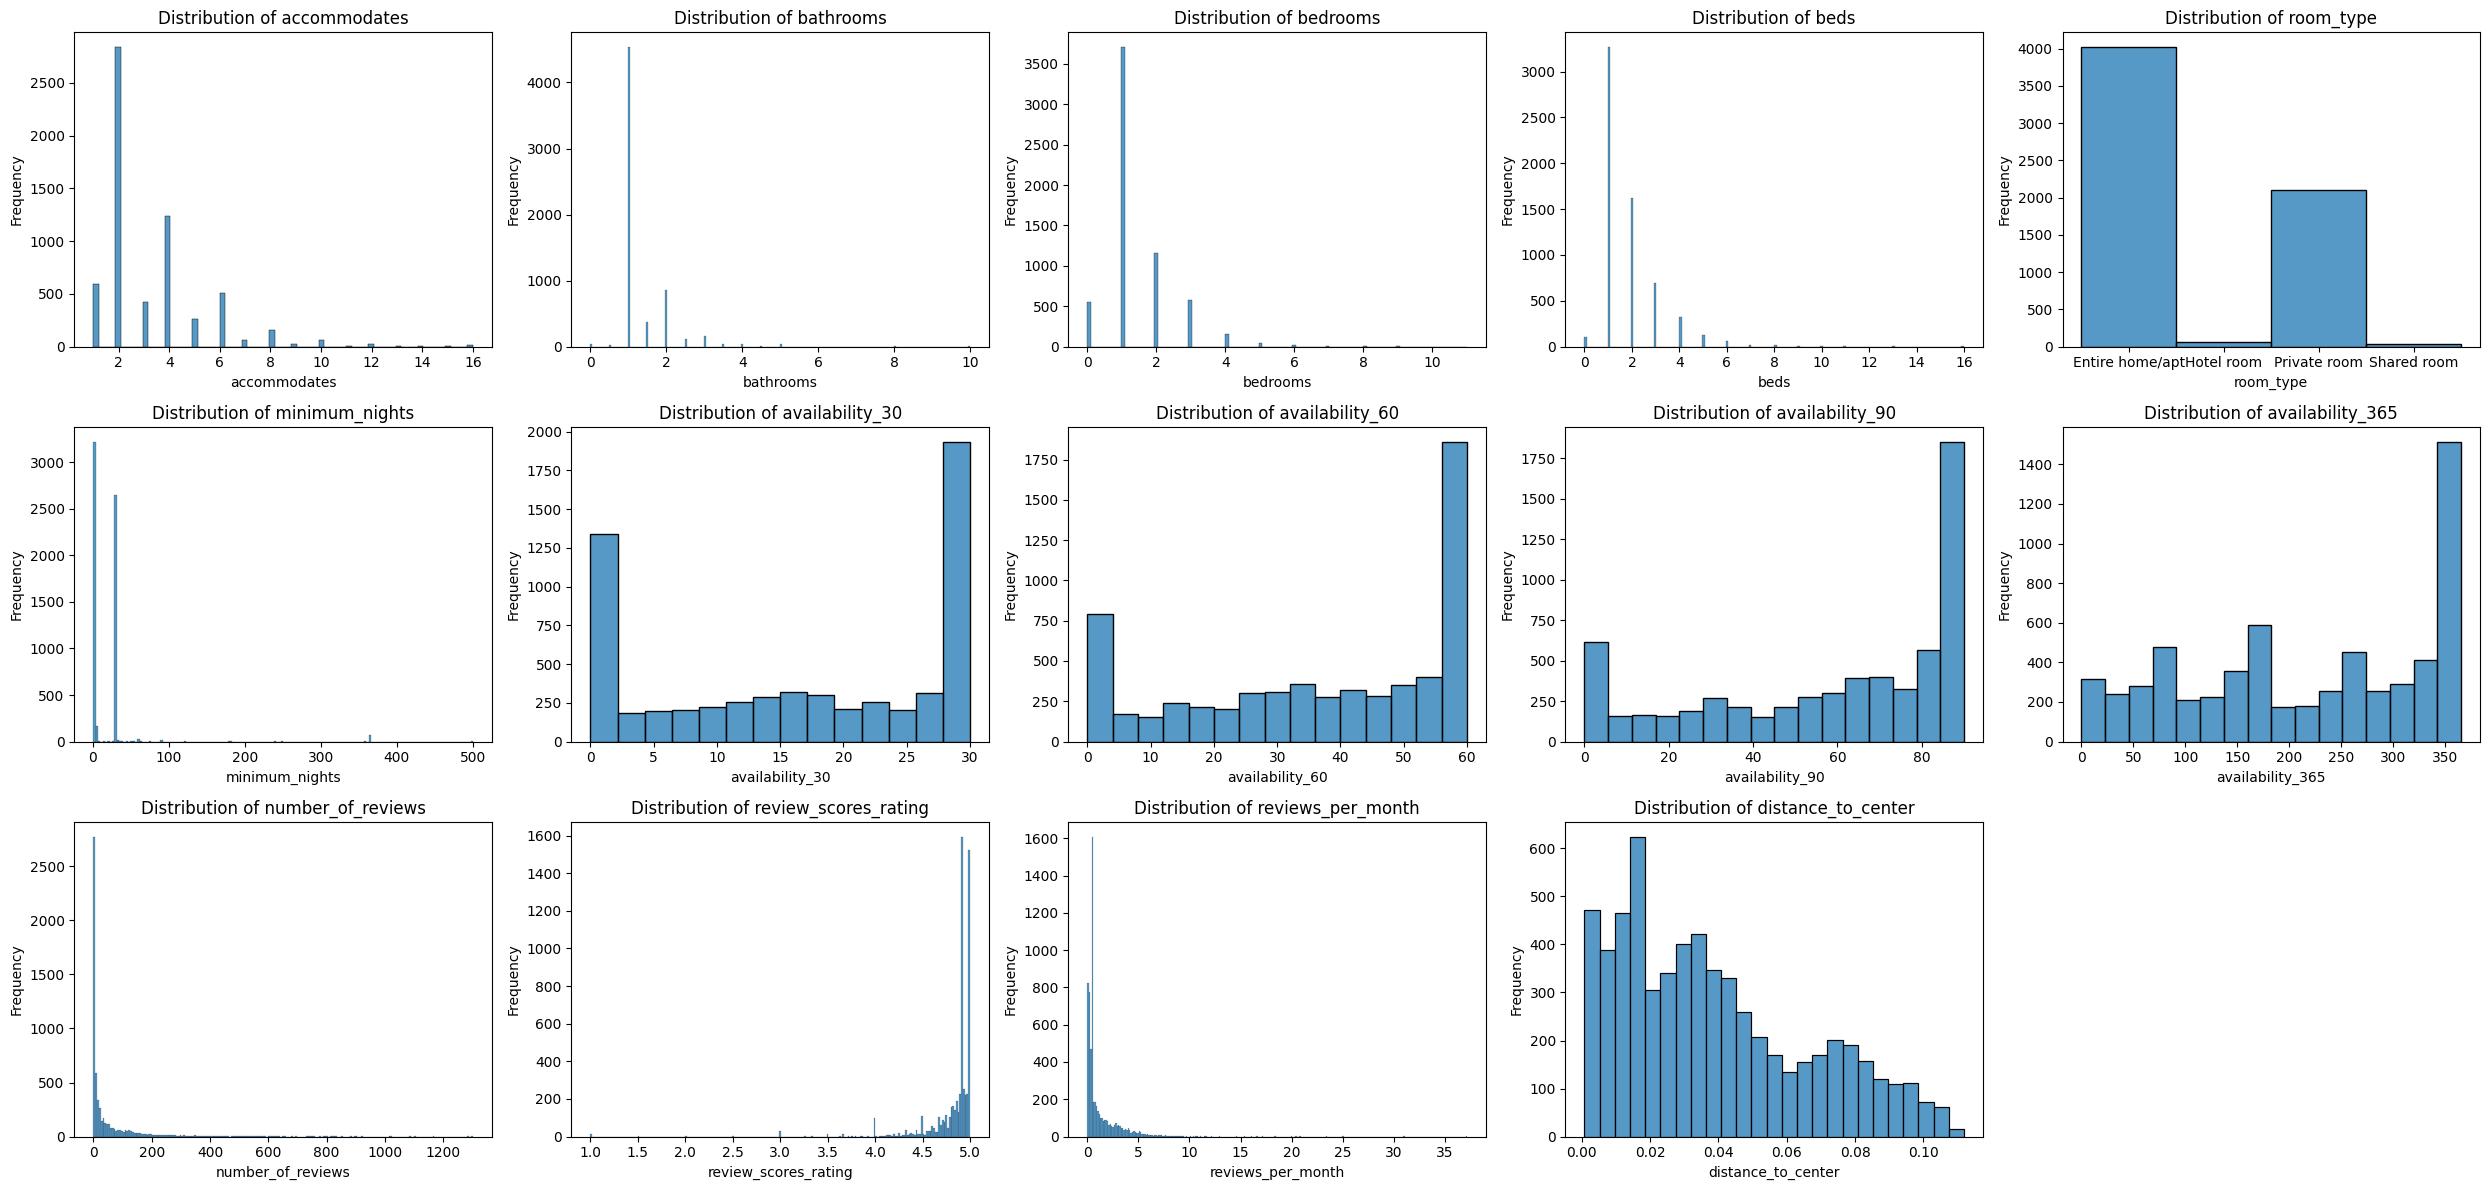

In [138]:
# List of variables to plot
variables = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "room_type",  # Needs encoding
    "minimum_nights",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "number_of_reviews",
    "review_scores_rating",
    "reviews_per_month",
    "distance_to_center",
]

# Calculate the number of columns needed
n_rows = 3
n_cols = (len(variables) + n_rows - 1) // n_rows

# Create a figure and axes
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each variable
for ax, var in zip(axes, variables):
    sns.histplot(df[var], ax=ax)
    ax.set_title(f"Distribution of {var}")
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")

# Remove any unused subplots
for i in range(len(variables), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

There looks to be acceptable variance in most of our variables, but symmetric unimodal distribution is rare.

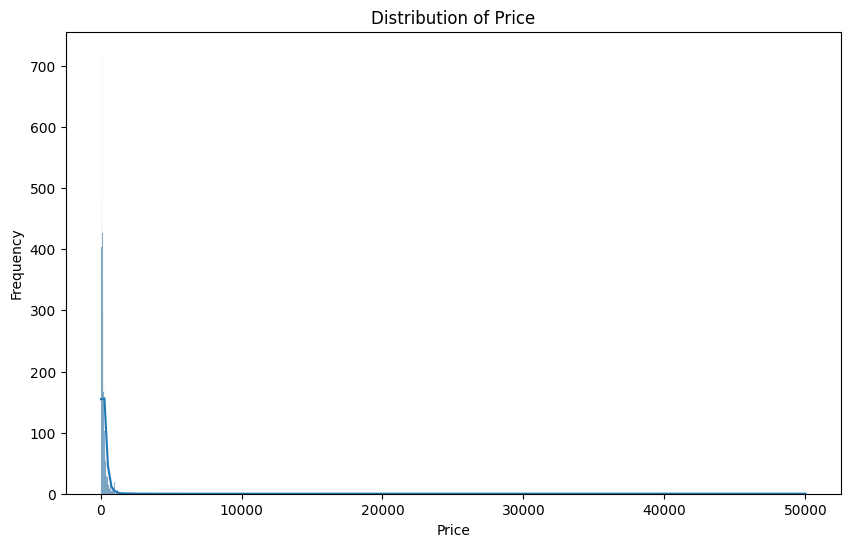

In [139]:
plt.figure(figsize=(10, 6))
sns.histplot(df["price"], kde=True)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of Price")
plt.show()

Price seems to face a data anomaly or possible data error with some overy erroneously large price(s)

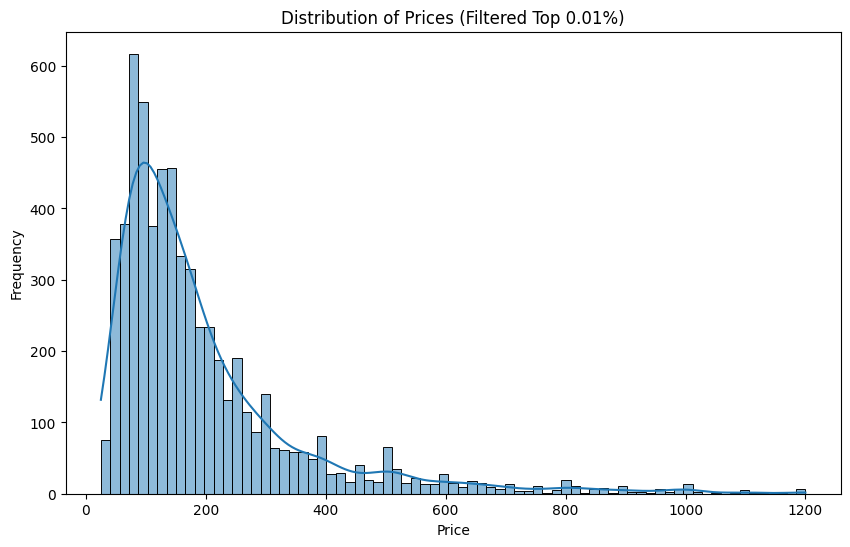

In [140]:
# Calculate the 99th percentile value for the price
price_cutoff = df["price"].quantile(0.99)

# Filter the dataframe to include only rows with price less than or equal to the 99.99th percentile value
filtered_df = df[df["price"] <= price_cutoff]

# Plot the distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["price"], kde=True)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of Prices (Filtered Top 0.01%)")
plt.show()

Dropping the top 1% of price seems to handle the issue. 
We want to include OLS and LASSO regression estimates on the same core set of data as with tree-based methods. In order not to introduce extreme instability for the former, I made the decision to drop them as part of the preprocessing pipeline. This step will be taken for the other two datasets too when conducting external validity checks.

In [141]:
# Calculate the 99th percentile value for the price
price_cutoff = df["price"].quantile(0.99)

# Filter the dataframe to include only rows with price less than or equal to the 99th percentile value
df = df[df["price"] <= price_cutoff]

# Display the new shape of the dataframe
print(df.shape)

(6169, 158)


Checking common relationships with price and most important variables

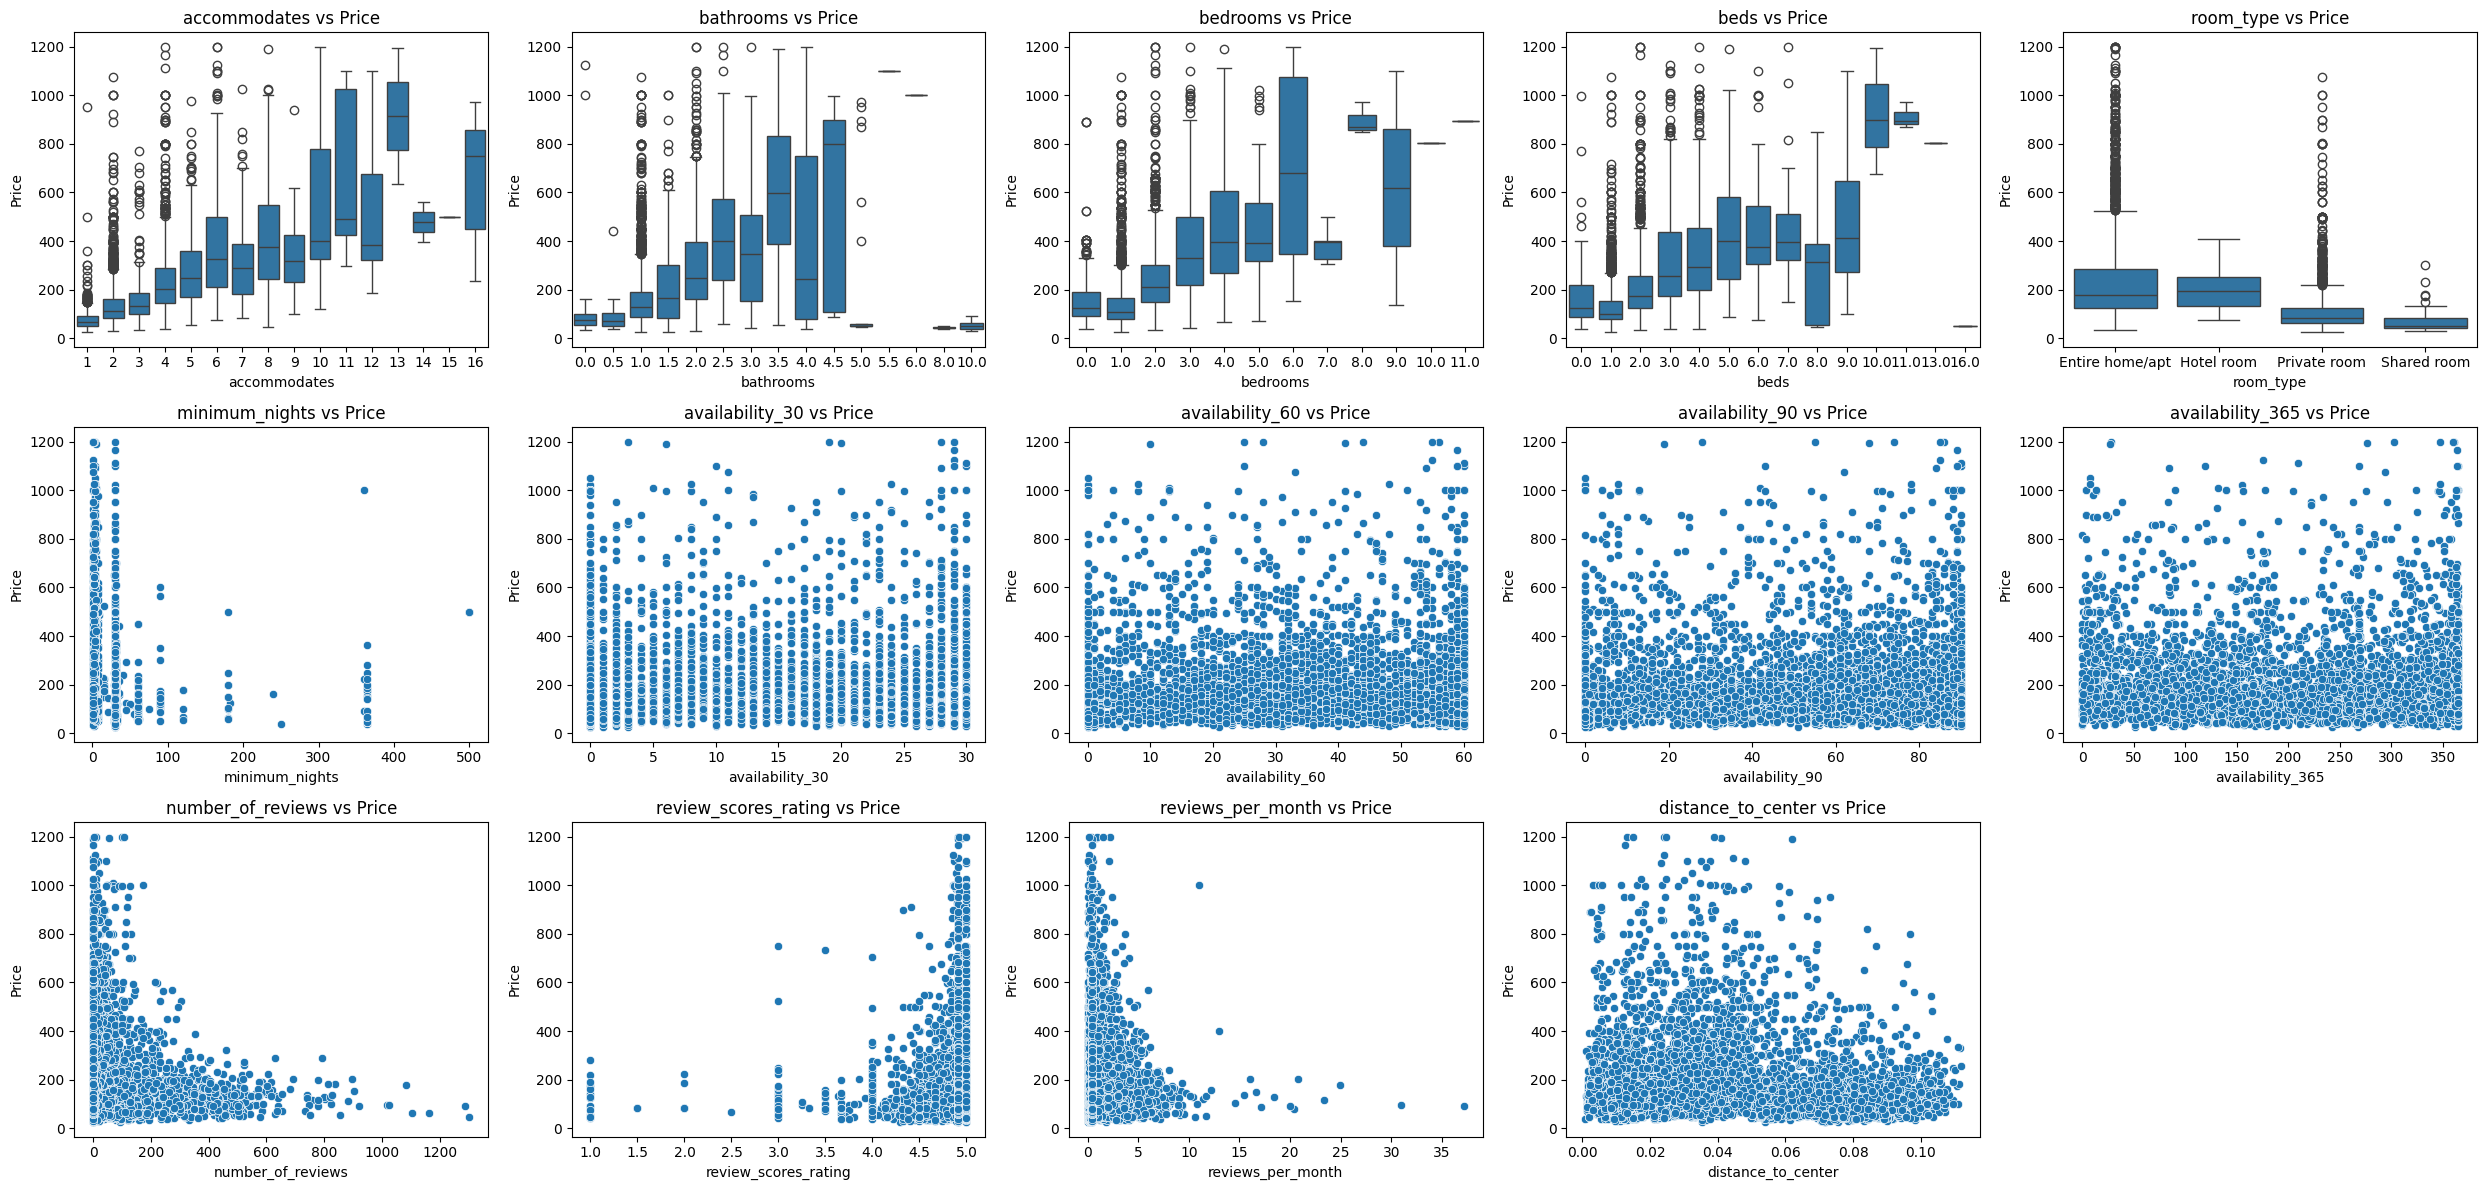

In [142]:
# List of variables for boxplots and scatterplots
boxplot_vars = ["accommodates", "bathrooms", "bedrooms", "beds", "room_type"]
scatterplot_vars = [
    "minimum_nights",
    # "maximum_nights", - too low variance
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "number_of_reviews",
    "review_scores_rating",
    "reviews_per_month",
    "distance_to_center",
]

# Calculate the number of columns needed
n_cols = 5
n_rows = 3

# Create a figure and axes
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each variable with boxplot
for ax, var in zip(axes[: len(boxplot_vars)], boxplot_vars):
    sns.boxplot(x=df[var], y=df["price"], ax=ax)
    ax.set_title(f"{var} vs Price")
    ax.set_xlabel(var)
    ax.set_ylabel("Price")

# Plot each variable with scatterplot
for ax, var in zip(axes[len(boxplot_vars) :], scatterplot_vars):
    sns.scatterplot(x=df[var], y=df["price"], ax=ax)
    ax.set_title(f"{var} vs Price")
    ax.set_xlabel(var)
    ax.set_ylabel("Price")

# Remove any unused subplots
for i in range(len(boxplot_vars) + len(scatterplot_vars), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Defining formulas

In [143]:
target = "price"
interaction_terms = [
    # "C(accommodates):bedrooms",
    # "C(accommodates):bathrooms", Accommodates cannot be categorical
    "number_of_reviews:review_scores_rating",
    "distance_to_center:room_type",
    "distance_to_center:accommodates",
]

minimal_features = [
    "distance_to_center",
    "bedrooms",
    "beds",
    # "accommodates",
    "bathrooms",
    "room_type",
]

base_features = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "room_type",
    "minimum_nights",
    # "maximum_nights", - too low variance, introduces instability
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "number_of_reviews",
    "review_scores_rating",
    "reviews_per_month",
    "distance_to_center",
]

feature_sets = {
    "feature_set_0": minimal_features,
    "feature_set_1": base_features,
    "feature_set_2": base_features + interaction_terms,
    "feature_set_3": base_features
    + amenity_category_any_columns
    + amenity_category_coverage_columns,
    "feature_set_4": base_features + amenity_granular_columns,
    # adding interaction terms or extending the list of variables will lead to overfitting
    "feature_set_4_b": base_features + amenity_granular_columns + interaction_terms,
    "feature_set_5": base_features
    + amenity_granular_columns
    + amenity_category_any_columns
    + amenity_category_coverage_columns,
    "feature_set_6": extended_source_features + amenity_granular_columns,
    "feature_set_7": extended_source_features
    + amenity_granular_columns
    + amenity_category_any_columns
    + amenity_category_coverage_columns,
}


Interaction terms are ommitted from our analysis. This is because introducing any of them introduced such model instability, that test-set rmse became orders of magnitude higher than train. Tree-based methods inherently gauge interactive relationships, so only our ols

Leveraging patsy to create the abovementioned subsets of data.

In [144]:
# Define formulas for each feature set
formulas = {
    f"formula_{i}": create_formula(df, target, features)
    for i, features in feature_sets.items()
}

# Print the formulas
formulas


{'formula_feature_set_0': 'price ~ distance_to_center + bedrooms + beds + bathrooms + C(room_type)',
 'formula_feature_set_1': 'price ~ accommodates + bathrooms + bedrooms + beds + C(room_type) + minimum_nights + availability_30 + availability_60 + availability_90 + availability_365 + number_of_reviews + review_scores_rating + reviews_per_month + distance_to_center',
 'formula_feature_set_2': 'price ~ accommodates + bathrooms + bedrooms + beds + C(room_type) + minimum_nights + availability_30 + availability_60 + availability_90 + availability_365 + number_of_reviews + review_scores_rating + reviews_per_month + distance_to_center + number_of_reviews:review_scores_rating + distance_to_center:room_type + distance_to_center:accommodates',
 'formula_feature_set_3': 'price ~ accommodates + bathrooms + bedrooms + beds + C(room_type) + minimum_nights + availability_30 + availability_60 + availability_90 + availability_365 + number_of_reviews + review_scores_rating + reviews_per_month + distanc

# Primary prediction analysis

San Francisco Q4 model selection

## OLS

In [145]:
smp_size = round(0.2 * df.shape[0]) - 1
smp_size

1233

In [146]:
np.random.seed(20250217)

# df_work, df_holdout = train_test_split(df, test_size=smp_size)
# print(f"Training set size: {df_work.shape[0]}")
# print(f"Holdout set size: {df_holdout.shape[0]}")
# instead of holdout, we compare for external validation after CV model selection
n_folds = 5
k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

In [147]:
ols_cv_list = []
for key, formula in formulas.items():
    ols_cv_list += [cv_reg(formula, df, k, "HC0")]


In [148]:
summarize_cv(ols_cv_list).map("{:,.3f}".format)

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8,Model9
Fold1,130.203,123.049,120.441,115.259,111.052,109.358,110.652,110.109,109.693
Fold2,128.952,122.538,119.917,115.045,111.482,109.696,111.033,110.720,110.268
Fold3,127.220,121.564,119.522,114.440,111.196,109.668,110.566,110.058,109.423
Fold4,128.397,122.661,120.067,115.403,111.474,109.921,111.081,110.704,110.312
Fold5,128.853,122.862,120.759,116.396,112.459,111.092,111.947,111.429,110.928
Average,128.725,122.535,120.141,115.308,111.532,109.947,111.056,110.604,110.125


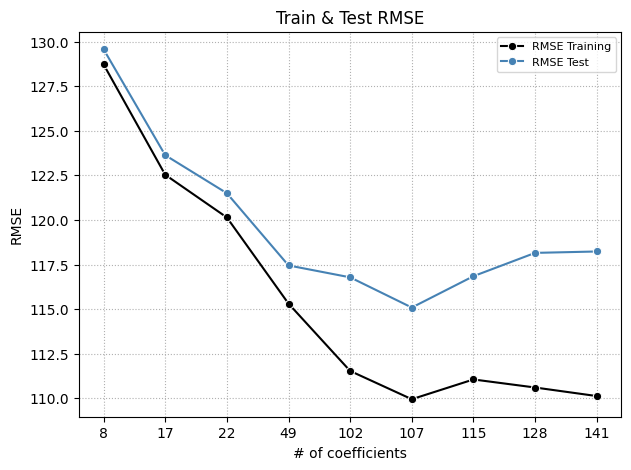

In [149]:
# Plot fit with increasing number of features involved
ols_rmse_levels = {"nvars": [], "var": [], "value": []}
n_models = len(ols_cv_list)
for i in range(0, n_models):
    ols_rmse_levels["nvars"].append(int(ols_cv_list[i]["nvars"]))
    ols_rmse_levels["var"].append("RMSE Training")
    ols_rmse_levels["value"].append(pd.Series(ols_cv_list[i]["rmse"]).mean())
for i in range(0, n_models):
    ols_rmse_levels["nvars"].append(int(ols_cv_list[i]["nvars"]))
    ols_rmse_levels["var"].append("RMSE Test")
    ols_rmse_levels["value"].append(pd.Series(ols_cv_list[i]["rmse_test"]).mean())
ols_df_rmse_levels = pd.DataFrame.from_dict(ols_rmse_levels)
ols_df_rmse_levels["nvars2"] = ols_df_rmse_levels["nvars"] + 1
plt.figure(figsize=(7, 5))
ax = sns.lineplot(
    x=[str(x) for x in ols_df_rmse_levels["nvars2"]],
    y=ols_df_rmse_levels["value"],
    hue=ols_df_rmse_levels["var"],
    marker="o",
    palette=["k", "steelblue"],
)
ax.set_title("Train & Test RMSE")
ax.set_ylabel("RMSE")
ax.set_xlabel("# of coefficients")
ax.legend(fontsize=8, title=None)
ax.grid(linestyle=":")
plt.show();

We seem to overfit our dataset consistently with OLS.

The best model in terms of avoiding overfitting is model 4. It includes the base features of analysis and the core set of variables.
- I made the decision to only go onward with that defined set of features for model comparison, horserace and external validity checks.
- Itcould be also interesting to plot for each prediction method the above graph, and make a decision on which version to involve.
- This is beyond the scope of this analysis though.
  


In [150]:
ols_rmse = np.array(ols_cv_list[3]["rmse"]).mean()

In [151]:
ols_rmse

np.float64(115.30848465016955)

## LASSO

In [152]:
y, X = patsy.dmatrices(formulas["formula_feature_set_4"], df)
# define model
model = Lasso()
# define model evaluation method
lasso_cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=20250217)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(
    model,
    grid,
    scoring="neg_root_mean_squared_error",
    cv=lasso_cv,
    verbose=1,
    return_train_score=True,
)  # control your output with the 'verbose' option
# perform the search
lasso_results = search.fit(X, y)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


In [153]:
lasso_rmse = lasso_results.best_score_ * -1  # because it is negative

In [154]:
print(f"RMSE: {(lasso_rmse):,.3f}")

RMSE: 114.557


In [155]:
lasso_best_alpha = lasso_results.best_params_["alpha"]
print(f"Final alpha: {lasso_best_alpha}")

Final alpha: 0.1


EXTRA: compare all linear models.

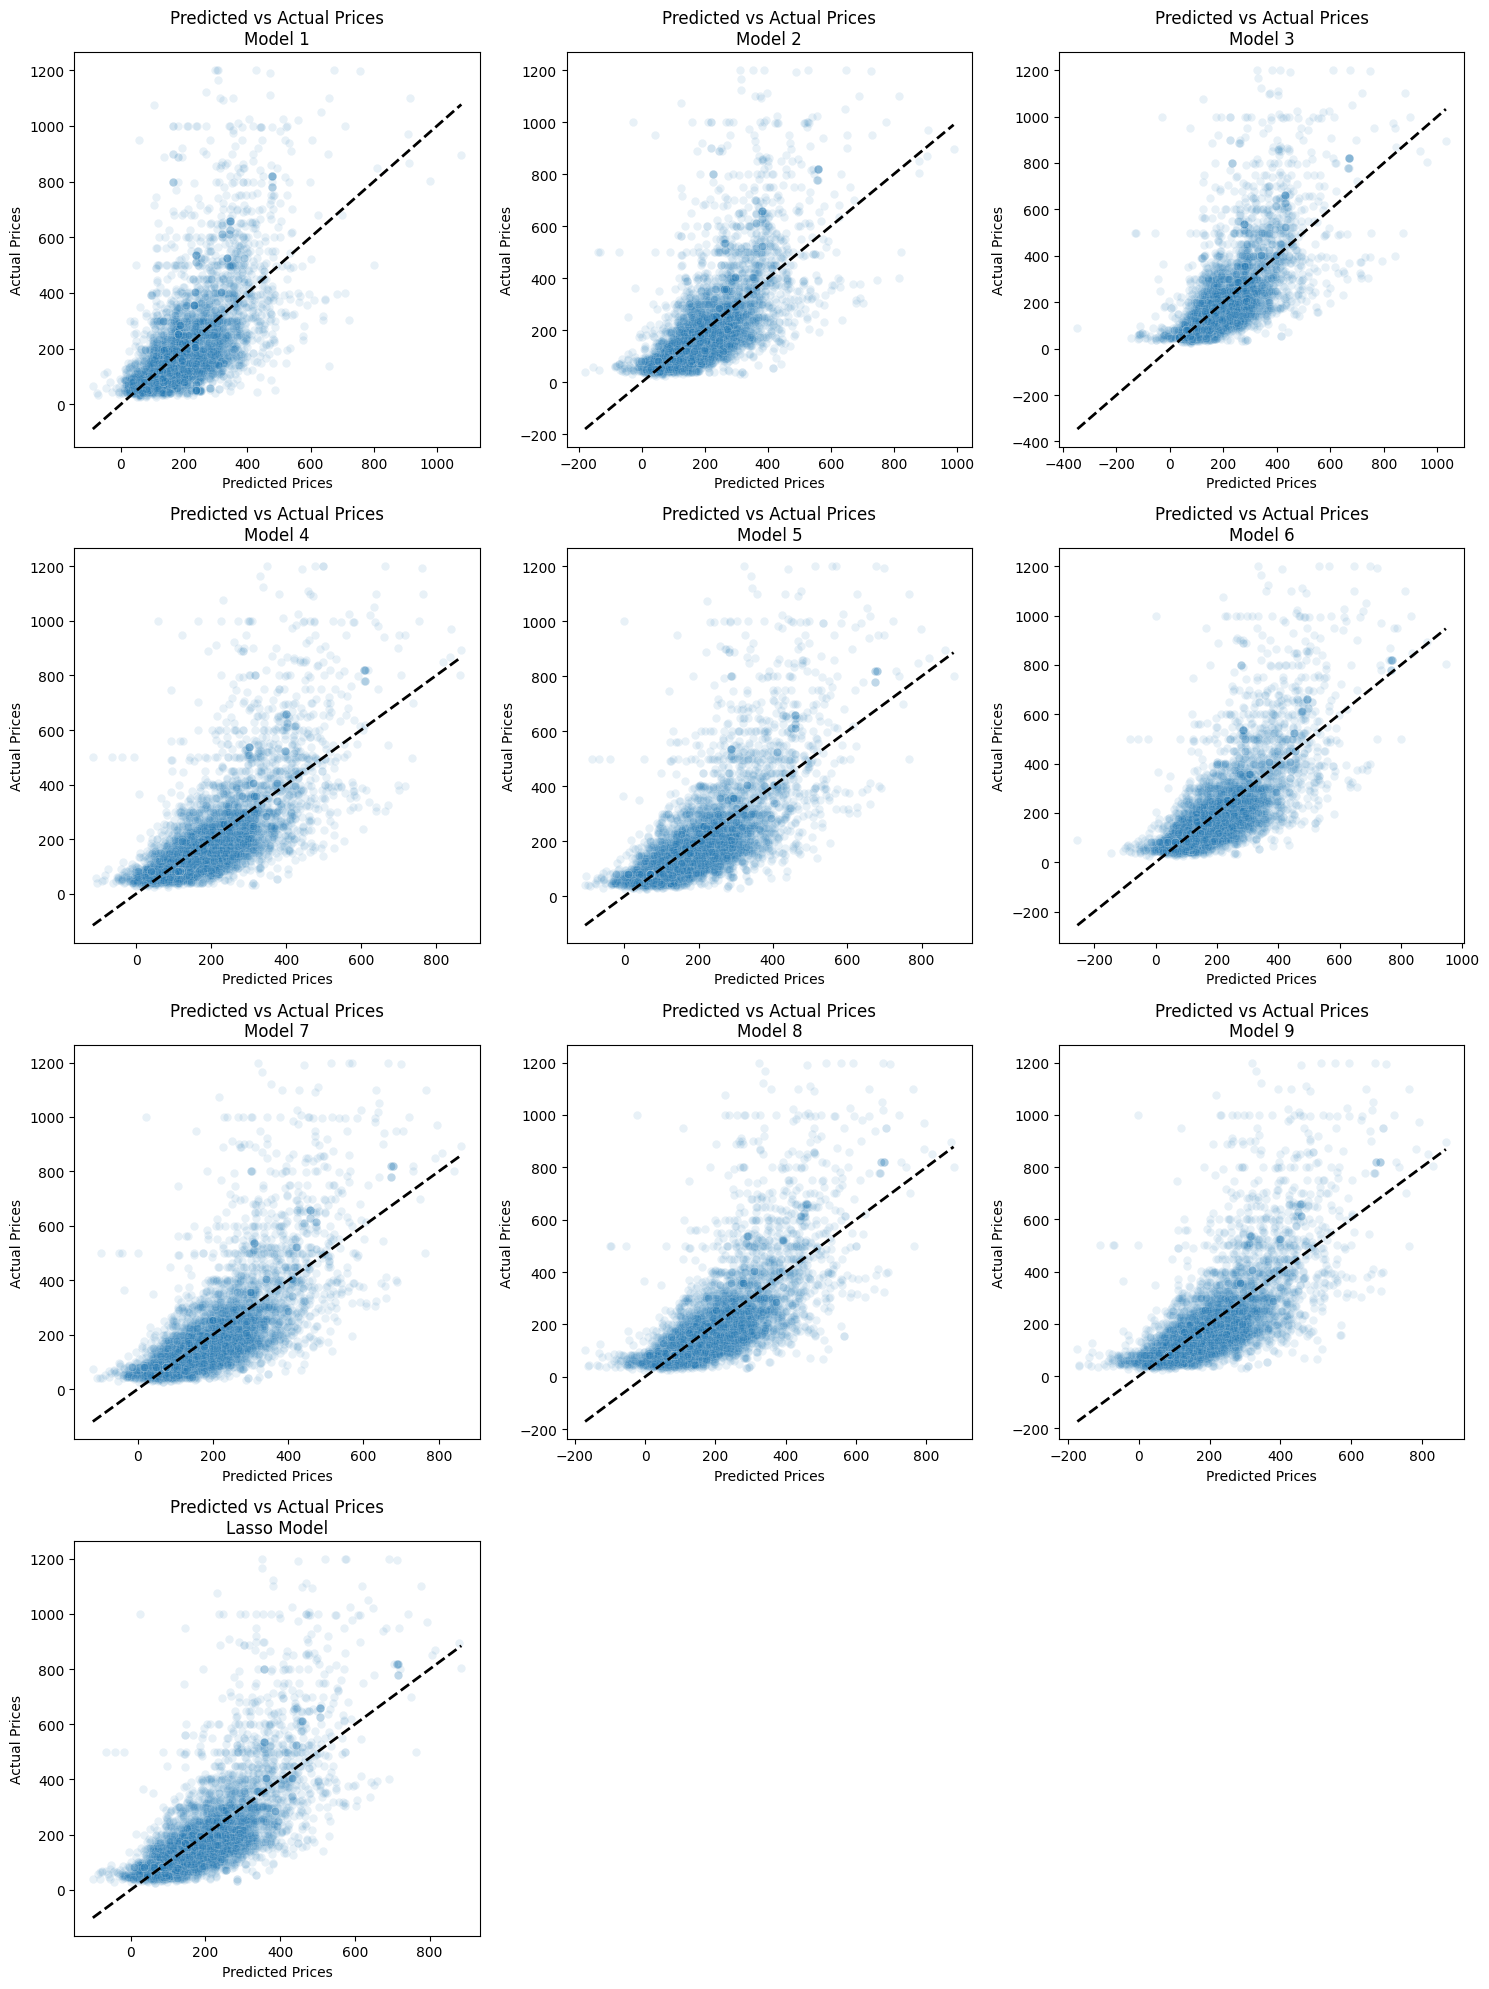

In [156]:
# Create a figure and axes
n_models = len(ols_cv_list) + 1  # Including the Lasso model
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each model's predicted vs actual prices
for ax, ols_cv_results, model_number in zip(
    axes, ols_cv_list, range(1, len(ols_cv_list) + 1)
):
    predicted_prices = pd.concat(ols_cv_results["test_predict"])
    actual_prices = df.loc[predicted_prices.index, "price"]
    sns.scatterplot(x=predicted_prices, y=actual_prices, ax=ax, alpha=0.1)
    ax.plot(
        [predicted_prices.min(), predicted_prices.max()],
        [predicted_prices.min(), predicted_prices.max()],
        "k--",
        lw=2,
    )
    ax.set_title(f"Predicted vs Actual Prices\nModel {model_number}")
    ax.set_xlabel("Predicted Prices")
    ax.set_ylabel("Actual Prices")

# Plot the Lasso model's predicted vs actual prices
lasso_ax = axes[len(ols_cv_list)]
lasso_predicted_prices = lasso_results.predict(X)
lasso_actual_prices = y.flatten()

sns.scatterplot(x=lasso_predicted_prices, y=lasso_actual_prices, ax=lasso_ax, alpha=0.1)
lasso_ax.plot(
    [lasso_predicted_prices.min(), lasso_predicted_prices.max()],
    [lasso_predicted_prices.min(), lasso_predicted_prices.max()],
    "k--",
    lw=2,
)
lasso_ax.set_title("Predicted vs Actual Prices\nLasso Model")
lasso_ax.set_xlabel("Predicted Prices")
lasso_ax.set_ylabel("Actual Prices")

# Remove any unused subplots
for i in range(n_models, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

We can see, that for higher priced apartments, our model does not capture the true relationship.

In [157]:
retrieve_cv_summary(lasso_results)

# Overfitting is still a problem

,estimator,alpha,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
1,Lasso,0.10,111.993764,0.765833,114.556773,3.170214,1
0,Lasso,0.05,111.805626,0.756756,114.582558,3.077941,2
2,Lasso,0.15,112.260430,0.768415,114.638459,3.221503,3
3,Lasso,0.20,112.595911,0.779927,114.786027,3.256130,4
4,Lasso,0.25,112.978104,0.797568,115.005133,3.278358,5
5,Lasso,0.30,113.390313,0.800678,115.282805,3.291257,6
6,Lasso,0.35,113.831998,0.791780,115.606774,3.309243,7
7,Lasso,0.40,114.160180,0.844644,115.841143,3.253232,8
8,Lasso,0.45,114.311345,0.833956,115.917684,3.244622,9
9,Lasso,0.50,114.450622,0.831334,115.998563,3.240601,10


## Random Forest

In [158]:
# for plotting purposes, and because these models are not linear, we have to separate a small holdout set. (Otherwise we would see a much increased fit)
df_work, df_holdout = train_test_split(df, train_size=smp_size, random_state=20250224)
print(f"Working set size: {df_work.shape[0]}")
print(f"Holdout set size: {df_holdout.shape[0]}")


Working set size: 1233
Holdout set size: 4936


In [159]:
y, X = dmatrices(formulas["formula_feature_set_4"], df_work)
# Convert patsy DesignMatrix to NumPy arrays
X = np.asarray(X)  # Convert to a standard NumPy array
y = np.asarray(y).ravel()  # Flatten y to a 1D array

# Prepare the holdout set
y_holdout, X_holdout = dmatrices(formulas["formula_feature_set_4"], df_holdout)
X_holdout = np.asarray(X_holdout)
y_holdout = np.asarray(y_holdout).ravel()


In [160]:
# Define the random forest model
rf_model = RandomForestRegressor(random_state=20250224)

# Define the hyperparameter grid
random_forest_param_grid = {
    "n_estimators": [50, 100, 200],
    "min_samples_leaf": [5, 10, 15, 20],
    "max_features": [6, 8, 10, 12],
}

# Define the grid search
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=random_forest_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

# Fit the grid search
random_forest_results = grid_search.fit(X, y.ravel())

# Get the best parameters and best score
best_params = random_forest_results.best_params_
best_score = -random_forest_results.best_score_
average_train_rmse = np.mean(
    -random_forest_results.cv_results_["mean_train_score"]
)  # Avg RMSE on train data


print(f"Best Parameters: {best_params}")
print(f"Best Test RMSE: {best_score:.3f}")
print(f"Average Train RMSE: {average_train_rmse:.3f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'max_features': 12, 'min_samples_leaf': 5, 'n_estimators': 200}
Best Test RMSE: 106.349
Average Train RMSE: 104.002


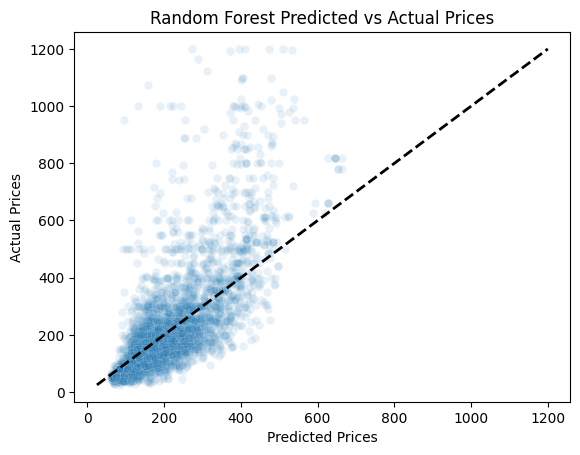

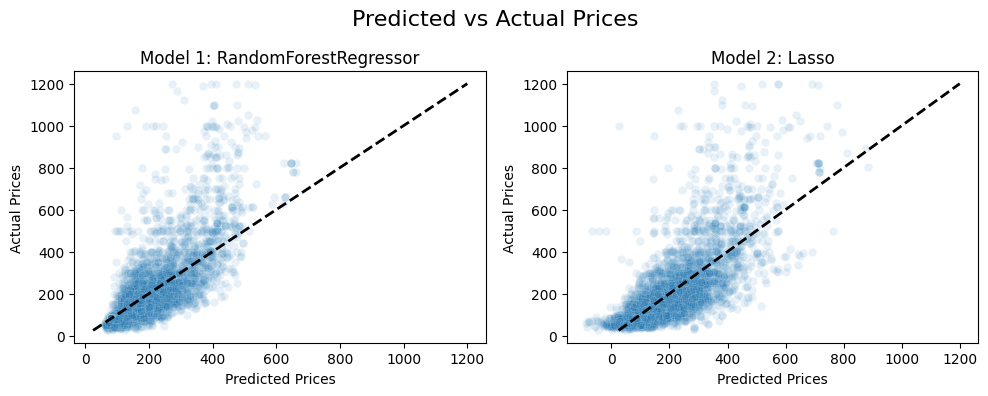

In [161]:
plot_predictions_vs_actuals(
    random_forest_results,
    X_holdout,
    y_holdout,
    title="Random Forest Predicted vs Actual Prices",
)

# Example usage:
plot_multiple_predictions_vs_actuals(
    [random_forest_results, lasso_results], X_holdout, y_holdout, n_rows=1
)


## Random forest with Gradient Boosting
- Decorrelating each tree in the ensemble.

In [162]:
# Define the boosting model
gb_model = GradientBoostingRegressor(
    learning_rate=0.1, min_samples_split=20, max_features=10, random_state=20250224
)

# Define a small hyperparameter grid
gbm_param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [5, 10, 100],
}


# Define the grid search
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=gbm_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

# Fit the grid search
gbm_results = grid_search.fit(X, y.ravel())

# Get the best parameters and best score
best_params = gbm_results.best_params_
best_score = -gbm_results.best_score_
average_train_rmse = np.mean(
    -gbm_results.cv_results_["mean_train_score"]
)  # Avg RMSE on train data

print(f"Best Parameters: {best_params}")
print(f"Best Test RMSE: {best_score:.3f}")
print(f"Average Train RMSE: {average_train_rmse:.3f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Best Test RMSE: 97.888
Average Train RMSE: 18.371


<Axes: title={'center': 'Gradient Boosting Predicted vs Actual Prices'}, xlabel='Predicted Prices', ylabel='Actual Prices'>

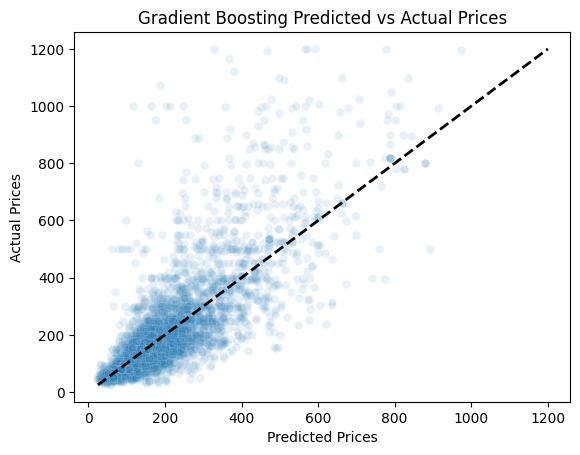

In [163]:
plot_predictions_vs_actuals(
    gbm_results,
    X_holdout,
    y_holdout,
    title="Gradient Boosting Predicted vs Actual Prices",
)

The gradient boosting method looks surprisingly effective in leveraging the amenity dummies and capturing more of the higher-end variations in the data.

## Decision Tree estimation - the extra

In [164]:
# Define the decision tree model
cart_model = DecisionTreeRegressor(random_state=20250224)

# Define the hyperparameter grid
param_grid = {
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 10, 20, 30, 40],
    "min_samples_leaf": [1, 5, 10, 20, 30],
    "max_features": [None, "sqrt", "log2"],
}  # ccp_alpha is not included because RandomisedSearchCV does not contain attribute param_grid, which messes with the downstream table summaries

# Define the grid search
grid_search = GridSearchCV(
    estimator=cart_model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

# Fit the grid search
cart_results = grid_search.fit(X, y.ravel())

# Get the best parameters and best score
best_params = cart_results.best_params_
best_score = -cart_results.best_score_
average_train_rmse = np.mean(
    -cart_results.cv_results_["mean_train_score"]
)  # Avg RMSE on train data

print(f"Best Parameters: {best_params}")
print(f"Best Test RMSE: {best_score:.3f}")
print(f"Average Train RMSE: {average_train_rmse:.3f}")

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 30, 'min_samples_split': 2}
Best Test RMSE: 112.249
Average Train RMSE: 105.355


<Axes: title={'center': 'Decision Tree Predicted vs Actual Prices'}, xlabel='Predicted Prices', ylabel='Actual Prices'>

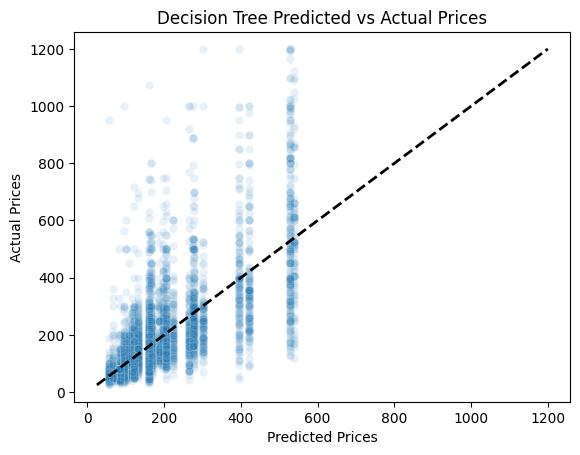

In [165]:
plot_predictions_vs_actuals(
    cart_results,
    X_holdout,
    y_holdout,
    title="Decision Tree Predicted vs Actual Prices",
)

# Horserace

In [166]:
# Here, we combine the results of the models into a single dataframe for comparison
# we can leverage the summarize_multiple_cv_results function, that takes a list of the estimators as an input
# the ols needs to be parametrically assigned to a different parameter. The model index is 4.

# Create a list of the models
models = [lasso_results, random_forest_results, gbm_results, cart_results]
horserace_df = summarize_multiple_cv_results(
    models, ols_cv_list=ols_cv_list, ols_model_number=4
)
horserace_df["mean_diff_test_train"] = (
    horserace_df["mean_test_score"] - horserace_df["mean_train_score"]
)

In [167]:
# CART returns multiple estimators with the same rank and RMSE scores, so we drop duplicates
horserace_df[horserace_df["rank_test_score"] == 1].drop_duplicates(
    subset=["estimator", "rank_test_score"]
)

,estimator,mean_test_score,mean_train_score,mean_diff_test_train,std_test_score,std_train_score,rank_test_score,alpha,n_estimators,min_samples_leaf,max_features,max_depth,min_samples_split
0,Lasso,114.556773,111.993764,2.563009,3.170214,0.765833,1,0.1,NaN,NaN,NaN,NaN,NaN
19,RandomForestRegressor,106.349363,85.505620,20.843743,15.791946,2.382687,1,NaN,200.0,5.0,12,NaN,NaN
82,DecisionTreeRegressor,112.249221,107.355689,4.893532,10.927054,3.475754,1,NaN,NaN,30.0,None,30,20.0
67,GradientBoostingRegressor,97.887902,45.305229,52.582673,12.526551,0.752264,1,NaN,100.0,NaN,NaN,5,NaN
102,OLS Model 4,116.782193,111.532309,5.249885,2.154115,0.491722,1,NaN,NaN,NaN,NaN,NaN,NaN


Boosting seems to massively overfit, but provide the best test performance. Lasso seems to least overfit, but is second to last in comparison.

## Comparison plot

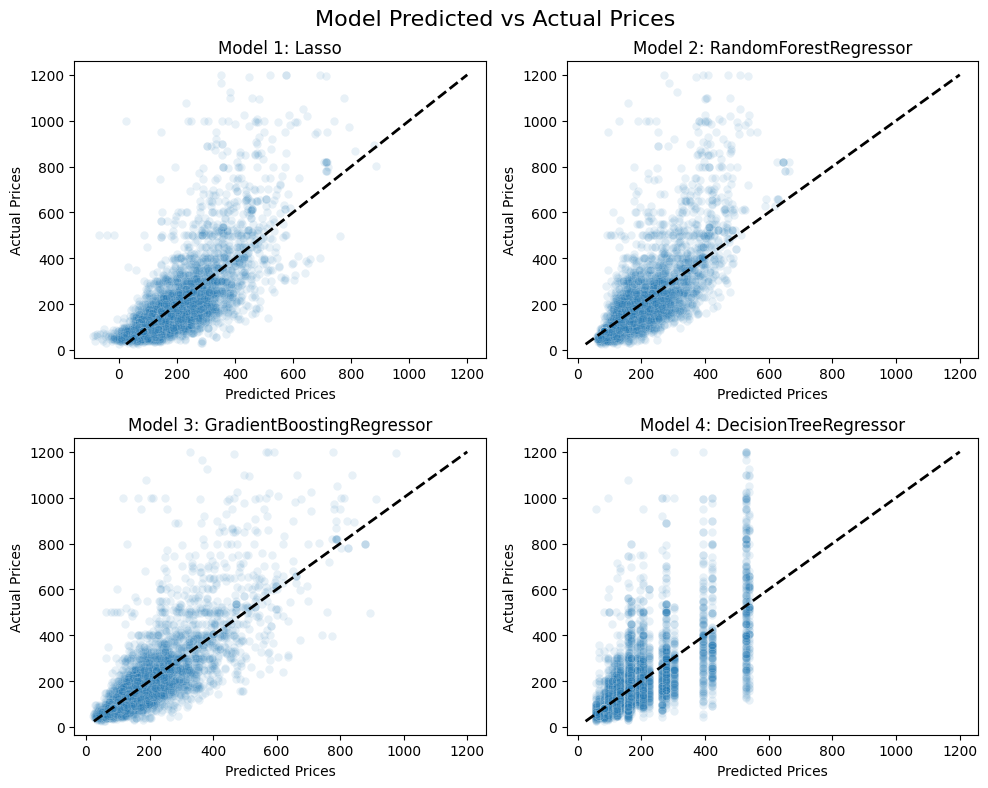

In [168]:
plot_multiple_predictions_vs_actuals(
    models,
    X_holdout,
    y_holdout,
    n_rows=2,
    main_title="Model Predicted vs Actual Prices",
)

Models seem to improve performance in the higher price segments, but this may increase overfitting.

## Feature importance analysis

In [169]:
# redefine, to make feature name extraction possible - following train-test-split, this information is lost
y_redef, X_redef = dmatrices(formulas["formula_feature_set_4"], df)

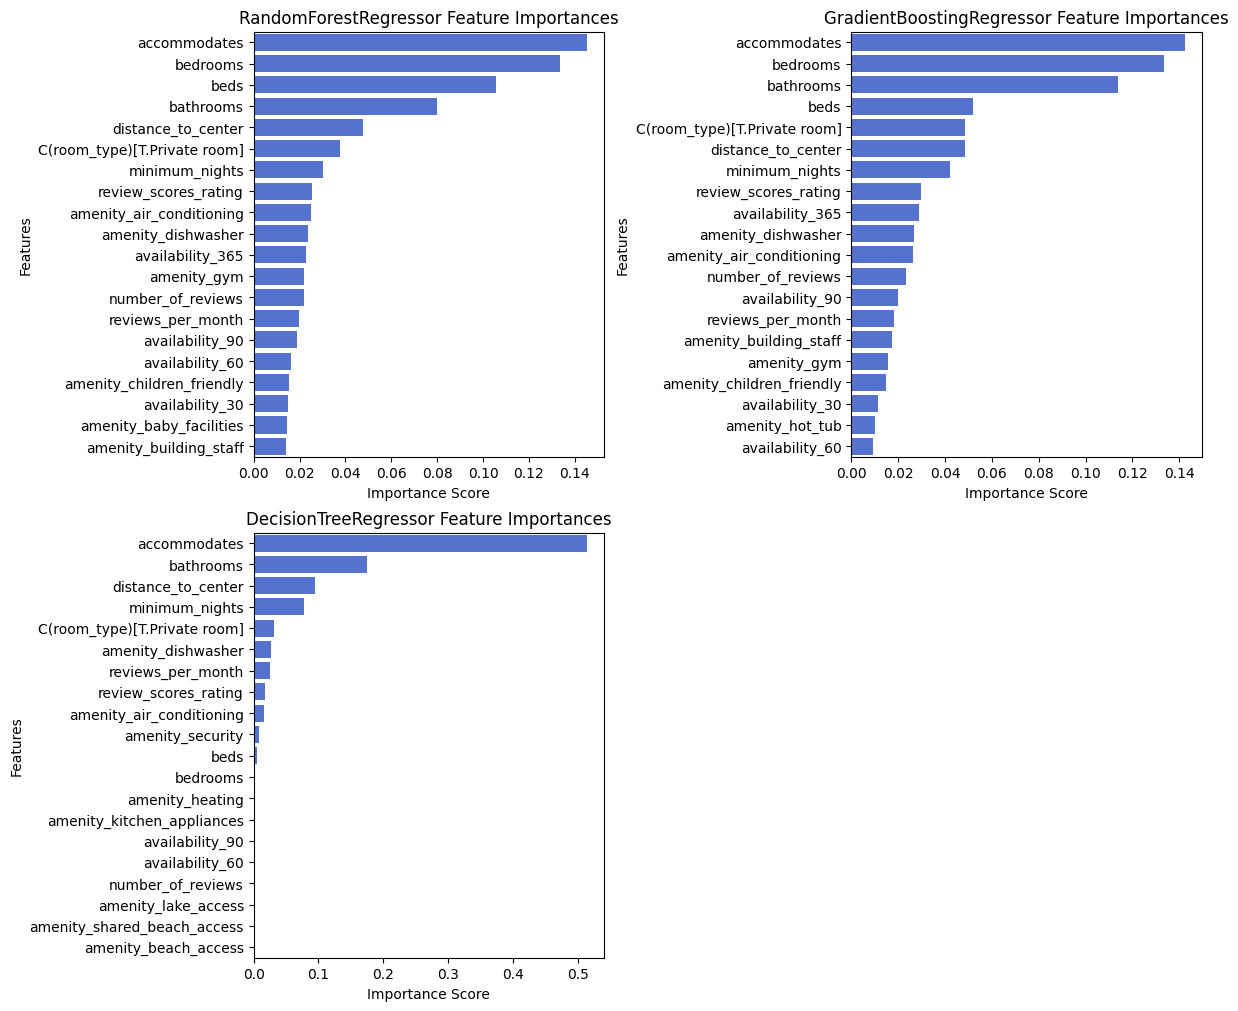

In [170]:
# Example usage
plot_feature_importances(
    [lasso_results, random_forest_results, gbm_results, cart_results],
    X_redef,
    top_n=20,
    n_rows=2,
)


- The CART seems to rely on much less information, as is expected.
- The Boosting seems to have a less smooth decline in feature importances down the order, with two flexible points apparent. 
  - The first three variables are more important, then there is a cutoff, and comes the rest. 
- Accomodates, bedrooms, bathrooms, and number of beds dominate the charts, with distance to center and being a private room coming after.
- Air conditioning, dishwasher, and year-round availability seems to also be important.

# Comparing to out-of-data

## Comparing San Francisco Q4 to San Francisco Q1.
Although the task was to compare to a later time period, the amenity feature extraction pipeline was optimized on San Francisco Q4. Hence, that is the base time frame.
- This is because I read the assignment not carefully enough.

In [171]:
df_san_francisco_q1 = pd.read_csv("San Francisco Q1.csv")

In [172]:
preprocessed_df = preprocess_data(
    df_san_francisco_q1,
    full_feature_set + [target],
    union_square_latitude,
    union_square_longitude,
)

Processing patterns: 100%|██████████| 86/86 [00:11<00:00,  7.78it/s]
c:\Users\ijara_go12\CEUProjects\Winter\da3-assignment-1\utils\preprocess.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["host_response_rate"].fillna(df["host_response_rate"].median(), inplace=True)
c:\Users\ijara_go12\CEUProjects\Winter\da3-assignment-1\utils\preprocess.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This i

In [173]:
y_q1, X_q1 = dmatrices(formulas["formula_feature_set_4"], preprocessed_df)

In [174]:
# Iterate over all models and calculate mean_test_score
model_scores = []
for model in models:
    model_name = type(model.best_estimator_).__name__
    y_q1_pred = model.predict(X_q1)
    y_pred = model.predict(X)
    rmse_q1 = root_mean_squared_error(y_q1, y_q1_pred)
    rmse_q4 = root_mean_squared_error(y, y_pred)
    cv_rmse_q4 = -model.best_score_

    model_scores.append(
        {
            "estimator": model_name,
            "mean_test_score_q1": rmse_q1,
            "mean_test_score_q4_full": rmse_q4,
            "mean_test_score_q4_cv": cv_rmse_q4,
            # "predictions_array_q1": y_q1_pred,
            # "predictions_array_q4": y_pred,
        }
    )

# Convert to DataFrame for better visualization
model_scores_df_q1_q4 = pd.DataFrame(model_scores)

# Display the table
model_scores_df_q1_q4

,estimator,mean_test_score_q1,mean_test_score_q4_full,mean_test_score_q4_cv
0,Lasso,106.851399,105.676579,114.556773
1,RandomForestRegressor,102.984427,84.961191,106.349363
2,GradientBoostingRegressor,97.488414,49.496164,97.887902
3,DecisionTreeRegressor,111.930888,102.336374,112.249221


In summary, our San Francisco Q4 models were all acceptably fitting on Q1. All model fittings seem to improve compared to the cross-validated test means.


In [175]:
import zipfile
import pandas as pd

# Path to the zip file
zip_file_path = "Los Angeles Q4.zip"

# Extract the CSV file from the zip archive
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall()

# Read the CSV file into a DataFrame
df_los_angeles_q4 = pd.read_csv("Los Angeles Q4.csv")

In [176]:
downtown_LA_latitude = 34.0522
downtown_LA_longitude = -118.2437

In [177]:
preprocessed_df = preprocess_data(
    df_los_angeles_q4,
    full_feature_set + [target],
    downtown_LA_latitude,
    downtown_LA_longitude,
)

Processing patterns: 100%|██████████| 86/86 [01:00<00:00,  1.43it/s]
c:\Users\ijara_go12\CEUProjects\Winter\da3-assignment-1\utils\preprocess.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["host_response_rate"].fillna(df["host_response_rate"].median(), inplace=True)
c:\Users\ijara_go12\CEUProjects\Winter\da3-assignment-1\utils\preprocess.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This i

In [178]:
y_la, X_la = dmatrices(formulas["formula_feature_set_4"], preprocessed_df)

In [179]:
# Iterate over all models and calculate mean_test_score for Los Angeles data
model_scores_la = []
for model in models:
    model_name = type(model.best_estimator_).__name__
    y_la_pred = model.predict(X_la)
    y_pred = model.predict(X)
    rmse_la = root_mean_squared_error(y_la, y_la_pred)
    rmse_sf = root_mean_squared_error(y, y_pred)
    cv_rmse_sf = -model.best_score_

    model_scores_la.append(
        {
            "estimator": model_name,
            "mean_test_score_la": rmse_la,
            "mean_test_score_sf_full": rmse_sf,
            "mean_test_score_sf_cv": cv_rmse_sf,
            # "predictions_array_la": y_la_pred,
            # "predictions_array_q4": y_pred,
        }
    )

# Convert to DataFrame for better visualization
model_scores_df_la_sf = pd.DataFrame(model_scores_la)

# Display the table
model_scores_df_la_sf

,estimator,mean_test_score_la,mean_test_score_sf_full,mean_test_score_sf_cv
0,Lasso,228.891439,105.676579,114.556773
1,RandomForestRegressor,220.526750,84.961191,106.349363
2,GradientBoostingRegressor,209.674796,49.496164,97.887902
3,DecisionTreeRegressor,220.354597,102.336374,112.249221


Our models are not as performant on the LA dataset, but none of the models seem to be dramatically worse than the othr. The Gradient Boosting seems to still outperform the others, rendering our fears of overfitting less dramatic.

In [ ]:
# Calculate the means for both df["price"] and preprocessed_df["price"]
mean_price_sf = df["price"].mean()
mean_price_la = preprocessed_df["price"].mean()

# Normalize all mean_test_scores in model_scores_df_la_sf
model_scores_df_la_sf["mean_test_score_la_normalized"] = (
    model_scores_df_la_sf["mean_test_score_la"] / mean_price_la
)
model_scores_df_la_sf["mean_test_score_sf_full_normalized"] = (
    model_scores_df_la_sf["mean_test_score_sf_full"] / mean_price_sf
)
model_scores_df_la_sf["mean_test_score_sf_cv_normalized"] = (
    model_scores_df_la_sf["mean_test_score_sf_cv"] / mean_price_sf
)

# Display the updated table
model_scores_df_la_sf

,estimator,mean_test_score_la,mean_test_score_sf_full,mean_test_score_sf_cv,mean_test_score_la_normalized,mean_test_score_sf_full_normalized,mean_test_score_sf_cv_normalized
0,Lasso,228.891439,105.676579,114.556773,1.010326,0.538328,0.583565
1,RandomForestRegressor,220.526750,84.961191,106.349363,0.973405,0.432802,0.541756
2,GradientBoostingRegressor,209.674796,49.496164,97.887902,0.925504,0.252139,0.498652
3,DecisionTreeRegressor,220.354597,102.336374,112.249221,0.972645,0.521313,0.571810


Normalizing with price, the same 1.5-2x increase is observable for all models.